#### Dataset: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

Casting defects are undesired irregularities in a metal casting process.  There are various kinds of these defects and depending on its severity and location almost always results in a part (or lot of parts) being scrapped.  Why?  Because these defects compromise the structural integrity of the part or the efficiency of the system it is installed into lead to sometimes catastropic failures.   Too often, the end result may be defined as somethnig else but the root cause points to a defect in the casting process.   For example, a crack may propagate within a hub leading to the destruction of an engine after many cycles but well before the life of the part.  

There are many inspection methods for catching casting defects and a many of them require a human being perfoming manual inspection of the product with the industry standard expectation of ~85% effectiveness for a single inspector.  Given a set of labelled images, this exercise attempts to beat this accuracy level by using machine learning classificaiton techniques.  

These all photos are top view of submersible pump impeller.  The dataset contains total 7348 images data. These all are the size of (300*300) pixels grey-scaled images with augmentation already applied to a randomly chosen training set.  There are two classes: 
 - Defective: later coded as 1
 - Ok: later coded as 0

### <span style="color:skyblue"> Import Libraries </span>

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os
import time

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.utils import plot_model

# sklearn
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

# plots
import seaborn as sns
import matplotlib.pyplot as plt

---
### <span style="color:skyblue"> Data Ingestion/EDA </span>

Loading the 2D images and their corresponding labels.

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 300, 300, 3)
    labels (np.ndarray): A numpy array of shape (N)
    '''
    ## load images and labels
    images = []
    labels = []

    for folder_name in os.listdir(path_to_data): 
        if folder_name != '.DS_Store': 
            folder_path = os.path.join(path_to_data, folder_name)
        
            for file_name in os.listdir(folder_path): 
                image_path = os.path.join(folder_path, file_name)
                image = load_img(image_path)
                image_arr = img_to_array(image)
                images.append(image_arr)
                labels.append(folder_name)
    
    return np.array(images), np.array(labels)

Data Paths & Class Distributions

X_train shape: (6633, 300, 300, 3)
y_train shape: (6633,)
X_test shape: (715, 300, 300, 3)
y_test shape: (715,)



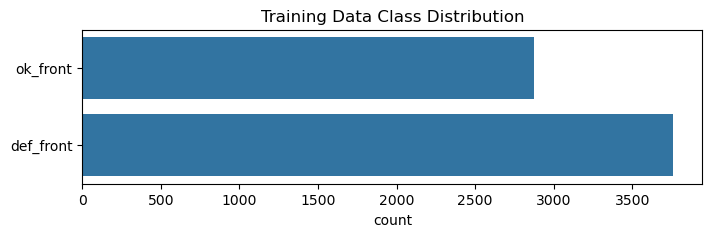

In [3]:
# Data Paths
path_to_data_train = 'casting_data/train'
path_to_data_test = 'casting_data/test'

# Train/Test Data
X_train, y_train = load_data(path_to_data_train)
X_test, y_test = load_data(path_to_data_test)

# Output shapes to check loading
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print()

# Review Class Distribution
plt.figure(figsize=(8,2))
sns.countplot(y_train).set(title='Training Data Class Distribution');

Display Example Images

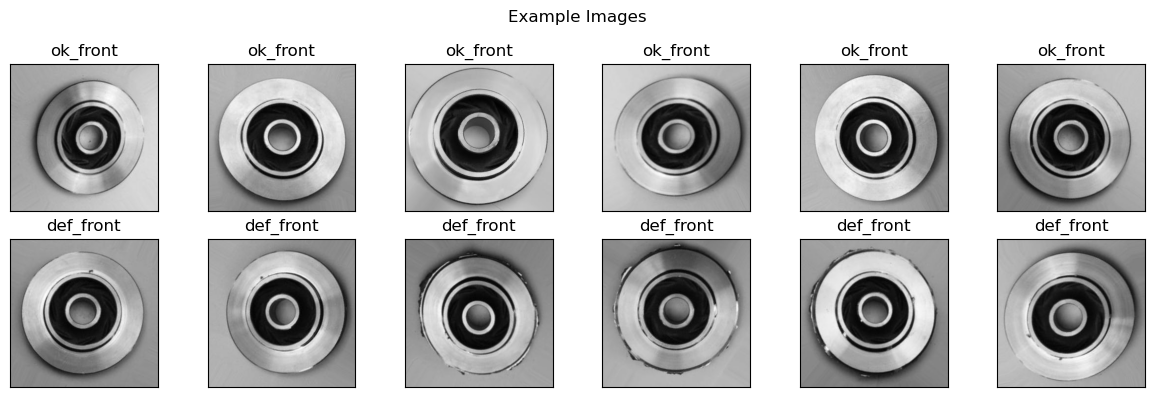

In [4]:
# Display Image Examples
image_dict = {}
dict_counter = 0
num_row = 2
num_col = 6
i = 0

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_col,2*num_row))
plt.suptitle('Example Images')

for ima, lab in zip(X_train, y_train): 
    if i > num_row*num_col:   # prevent from script from having to go through all training examples
        break

    if lab not in image_dict.keys():
        image_dict[lab] = [ima]

        ax = axes[i//num_col, i%num_col]
        ax.imshow(ima.astype('uint8'))
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(lab)
        i += 1

    elif len(image_dict[lab]) < num_col: 
        image_dict[lab].append(ima)

        ax = axes[i//num_col, i%num_col]
        ax.imshow(ima.astype('uint8'))
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(lab)
        i += 1
        # print(i)
        
    else:
        continue

plt.tight_layout()
plt.show()

Set Classes - defective class = 1; non-defective parts = 0

In [5]:
# Set Classes to 1 for defective parts and 0 for non-defective parts
y_train[y_train=='def_front'] = 1
y_train[y_train=='ok_front'] = 0
y_train = y_train.astype('int')

y_test[y_test=='def_front'] = 1
y_test[y_test=='ok_front'] = 0
y_test = y_test.astype('int')

Shuffle

In [6]:
# Shuffle x_train 
shuffle = np.random.permutation(np.arange(y_train.shape[0]))
X_train, y_train = X_train[shuffle], y_train[shuffle]

Normalize and Split Data

In [7]:
# Normalize
X_train = X_train / 255
X_test = X_test / 255

#Train, Test, Val Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

#Print Shapes
print('Train Shapes: ', X_train.shape, y_train.shape)
print('Validation Shapes: ', X_val.shape, y_val.shape)
print('Test Shapes: ', X_test.shape, y_test.shape)


Train Shapes:  (5306, 300, 300, 3) (5306,)
Validation Shapes:  (1327, 300, 300, 3) (1327,)
Test Shapes:  (715, 300, 300, 3) (715,)


### <span style="color:skyblue"> Baseline Prediction </span>

Baseline Prediction using Majority Class

In [8]:
# Use majority class
y_pred = np.ones(len(y_test))
baseline_accuracy = np.sum(y_test==y_pred)/len(y_test)

print(f'Baseline Accuracy using Majority Class (Defective): {100*baseline_accuracy: .2f}%')

Baseline Accuracy using Majority Class (Defective):  63.36%


---
### <span style="color:skyblue"> Decision Forest </span>

In [9]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Number of features used for Decision Forests', features_shape)
print()

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Number of features used for Decision Forests 270000

Shape of train images  (5306, 270000)
Shape of train labels  (5306,)
Shape of val images  (1327, 270000)
Shape of test images  (715, 270000)


In [10]:
start_time = time.time()

rfc_baseline = ensemble.RandomForestClassifier(
    n_estimators=2,
    n_jobs=1,
    random_state=1234,
    max_depth=3
)
rfc_baseline.fit(X_train_re, y_train)

print(f'Baseline Random Forest Training Accuracy: {rfc_baseline.score(X_train_re, y_train)*100: .2f}%')
print(f'Baseline Random Forest Validation Accuracy: {rfc_baseline.score(X_val_re, y_val)*100: .2f}%')
print(f'Baseline Random Forest Test Accuracy: {rfc_baseline.score(X_test_re, y_test)*100: .2f}%')
print(f'Execution Time: {time.time() - start_time: .2f} secs')

Baseline Random Forest Training Accuracy:  80.85%
Baseline Random Forest Validation Accuracy:  79.20%
Baseline Random Forest Test Accuracy:  79.02%
Execution Time:  2.45 secs


In [11]:
start_time = time.time()
rfc = ensemble.RandomForestClassifier(random_state=1234)

param_grid = { 
    'n_estimators': [100, 250, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2, 7),
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_re, y_train)

best_params = CV_rfc.best_params_
print('Best Parameters: ', best_params)
print(f'Execution Time: {time.time() - start_time: .2f} secs')

/opt/anaconda3/envs/Keras/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Keras/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Keras/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/Keras/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(


Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
Execution Time:  13533.39 secs


In [12]:
# Run model wiht best parameters
start_time = time.time()
rfc_model = ensemble.RandomForestClassifier(random_state=1234, 
                                            max_features='sqrt', 
                                            n_estimators= 500, 
                                            max_depth=6, 
                                            criterion='gini')

rfc_model.fit(X_train_re, y_train)

print(f'Tuned Random Forest Training Accuracy: {rfc_model.score(X_train_re, y_train)*100: .2f}%')
print(f'Tuned Random Forest Validation Accuracy: {rfc_model.score(X_val_re, y_val)*100: .2f}%')
print(f'Tuned Random Forest Test Accuracy: {rfc_model.score(X_test_re, y_test)*100: .2f}%')
print(f'Execution Time: {time.time() - start_time: .2f} secs')

Tuned Random Forest Training Accuracy:  96.46%
Tuned Random Forest Validation Accuracy:  93.52%
Tuned Random Forest Test Accuracy:  94.27%
Execution Time:  227.63 secs


---
### <span style="color:skyblue"> Convolution Networks </span>

In [13]:
# Define Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy', 
verbose=1,
patience=4,
mode='max',
restore_best_weights=True)

Model: "baseline_conv2d_model_with_0.1_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 12)      588       
                                                                 
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 1)                 270001    
                                                                 
Total params: 270,589
Trainable params: 270,589
Non-trainable params: 0
_________________________________________________________________

Epoch 1/500


2024-07-31 01:37:50.565205: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


166/166 [==============================] - 7s 42ms/step - loss: 45.6202 - accuracy: 0.5658 - val_loss: 0.6844 - val_accuracy: 0.5682
Epoch 2/500
166/166 [==============================] - 7s 40ms/step - loss: 0.6856 - accuracy: 0.5635 - val_loss: 0.6919 - val_accuracy: 0.5682
Epoch 3/500
166/166 [==============================] - 7s 40ms/step - loss: 0.6866 - accuracy: 0.5662 - val_loss: 0.6902 - val_accuracy: 0.5682
Epoch 4/500
166/166 [==============================] - 7s 41ms/step - loss: 0.6882 - accuracy: 0.5613 - val_loss: 0.6896 - val_accuracy: 0.5682
Epoch 5/500
166/166 [==============================] - 7s 40ms/step - loss: 0.6867 - accuracy: 0.5616 - val_loss: 0.6840 - val_accuracy: 0.5682
Epoch 6/500
166/166 [==============================] - 7s 40ms/step - loss: 0.6862 - accuracy: 0.5586 - val_loss: 0.6853 - val_accuracy: 0.5682
Epoch 7/500
166/166 [==============================] - 7s 41ms/step - loss: 0.6860 - accuracy: 0.5662 - val_loss: 0.6840 - val_accuracy: 0.5682
Epo

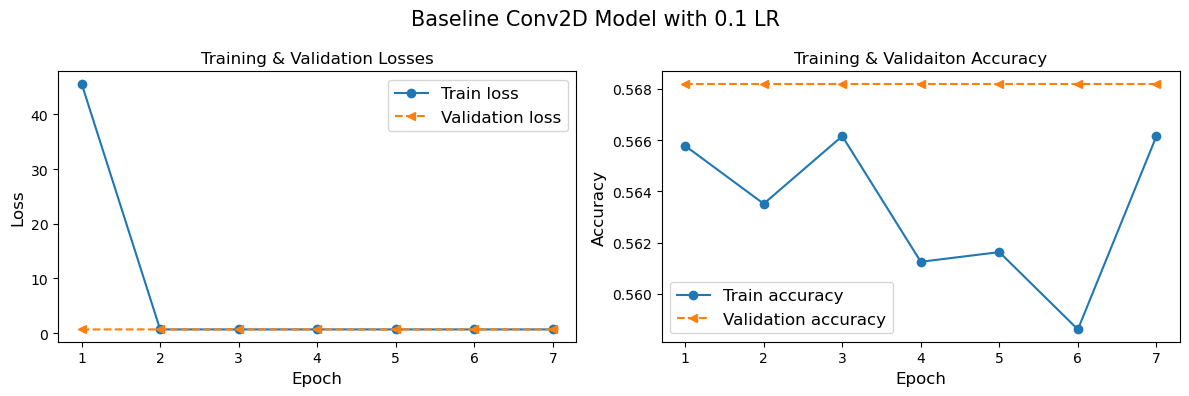

In [14]:
# Baseline Conv2D Model
start_time = time.time()

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(2, 2), 
                           padding='same', activation='relu', name='conv_1'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
], name='baseline_conv2d_model_with_0.1_LR')

model1.build()
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model1 summary
model1.summary()
print()

plot_model(model1, show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model1, show_shapes=True)

# Train Model1
history = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    callbacks=[early_stopping],
                    verbose=1)

# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
print()
print(f'Number of Parameters: {model1.count_params()}')
print(f'Training Accuracy: {100*model1.evaluate(X_train, y_train, verbose=0)[1]: .2f}%')
print(f'Validation Accuracy: {100*model1.evaluate(X_val, y_val, verbose=0)[1]: .2f}%')
print(f'Execution Time: {time.time() - start_time: .2f} secs')

# Plot Training and Validation Losses & Acccuracy 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
plt.suptitle('Baseline Conv2D Model with 0.1 LR', size=15)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('Training & Validation Losses')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation accuracy')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Accuracy', size=12)
ax.set_title('Training & Validaiton Accuracy')
# ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

Model: "baseline_conv2d_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 12)      588       
                                                                 
 flatten_1 (Flatten)         (None, 270000)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 270001    
                                                                 
Total params: 270,589
Trainable params: 270,589
Non-trainable params: 0
_________________________________________________________________

Epoch 1/500
166/166 [==============================] - 7s 41ms/step - loss: 0.8541 - accuracy: 0.6926 - val_loss: 0.4343 - val_accuracy: 0.8101
Epoch 2/500
166/166 [==============================] - 7s 40ms/step - loss: 0.3650 - accuracy: 0.8456 - val_loss: 0.3577 - val_accuracy: 0.8154
Epoch 3/500
16

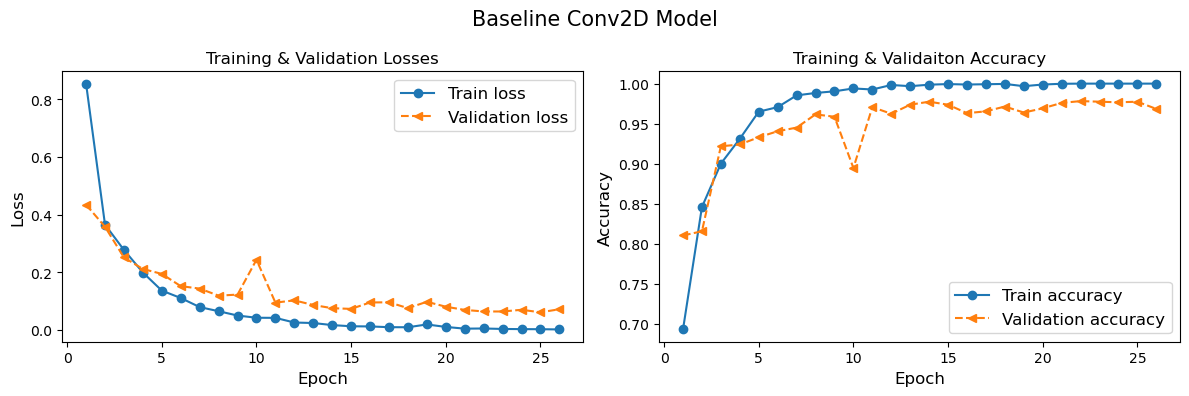

In [15]:
# Baseline Conv2D Model with lr=0.001
start_time = time.time()

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(2, 2), 
                           padding='same', activation='relu', name='conv_1'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
], name='baseline_conv2d_model')

model1.build()
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model1 summary
model1.summary()
print()

plot_model(model1, show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model1, show_shapes=True)

# Train Model1
history = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    callbacks=[early_stopping],
                    verbose=1)

# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
print()
print(f'Number of Parameters: {model1.count_params()}')
print(f'Training Accuracy: {100*model1.evaluate(X_train, y_train, verbose=0)[1]: .2f}%')
print(f'Validation Accuracy: {100*model1.evaluate(X_val, y_val, verbose=0)[1]: .2f}%')
print(f'Execution Time: {time.time() - start_time: .2f} secs')

# Plot Training and Validation Losses & Acccuracy 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
plt.suptitle('Baseline Conv2D Model', size=15)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('Training & Validation Losses')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation accuracy')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Accuracy', size=12)
ax.set_title('Training & Validaiton Accuracy')
# ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

Model: "enhanced_conv2D_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 12)      588       
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 75, 75, 12)        0         
                                                                 
 drop_out_1 (Dropout)        (None, 75, 75, 12)        0         
                                                                 
 conv_2 (Conv2D)             (None, 38, 38, 12)        2316      
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 19, 19, 12)        0         
                                                                 
 dropout_2 (Dropout)         (None, 19, 19, 12)        0         
                                                                 
 flatten (Flatten)           (None, 4332)    

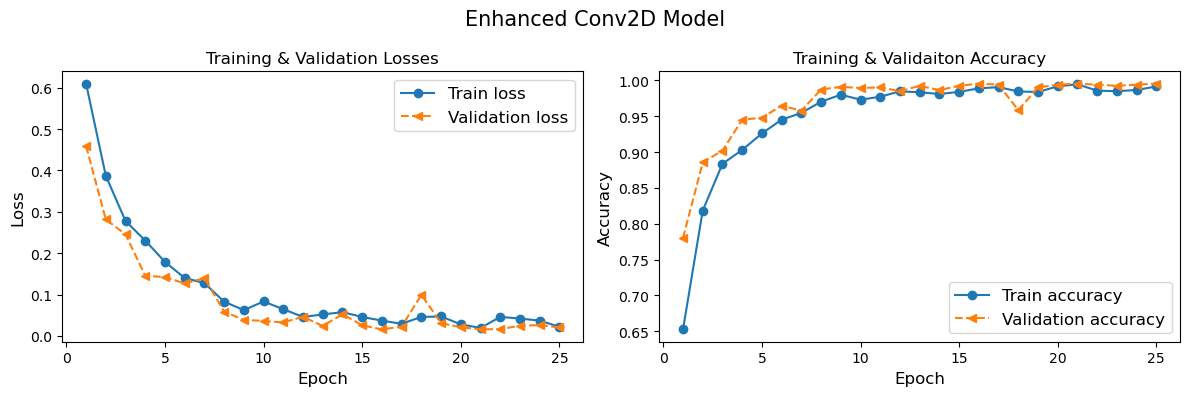

In [30]:
# More complicated Conv2D Model ...best solution found after trying several combinations of 
# layers (MaxPooling2D, Dropout) and tuning (learning rating, optimizer and number of units in the Dense layer)
start_time = time.time()

model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3), name="input_layer"),
    tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(2, 2), 
                           padding='same', activation='relu', name='conv_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max_pool_1'),
    tf.keras.layers.Dropout(rate=0.25, name='drop_out_1'), 

    tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(2, 2), 
                           padding='same', activation='relu', name='conv_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='max_pool_2'),
    tf.keras.layers.Dropout(rate=0.25, name='dropout_2'), 
    
    tf.keras.layers.Flatten(name='flatten'),

    tf.keras.layers.Dense(units=64, activation='relu', name='dense_1'),
    tf.keras.layers.Dense(units=64, activation='tanh', name='dense_2'),
    tf.keras.layers.Dense(units=32, activation='relu', name='dense_3'),
    
    tf.keras.layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name='enhanced_conv2D_model')

# model2.build()
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']) 

# print model1 summary
model2.summary()

# plot_model(model1, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(model1, show_shapes=True)

# Train Model1
history = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    callbacks=[early_stopping],
                    verbose=1)

# evaluate the accuracy of model1 on (X_train, y_train) and (X_val, y_val)
print()
print(f'Number of Parameters: {model2.count_params()}')
print(f'Training Accuracy: {100*model2.evaluate(X_train, y_train, verbose=0)[1]: .2f}%')
print(f'Validation Accuracy: {100*model2.evaluate(X_val, y_val, verbose=0)[1]: .2f}%')
print(f'Execution Time: {time.time() - start_time: .2f} secs')

# Plot Training and Validation Losses & Acccuracy 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
plt.suptitle('Enhanced Conv2D Model', size=15)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.set_title('Training & Validation Losses')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation accuracy')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Accuracy', size=12)
ax.set_title('Training & Validaiton Accuracy')
# ax.set_ylim(0,1)

plt.tight_layout()
plt.show()

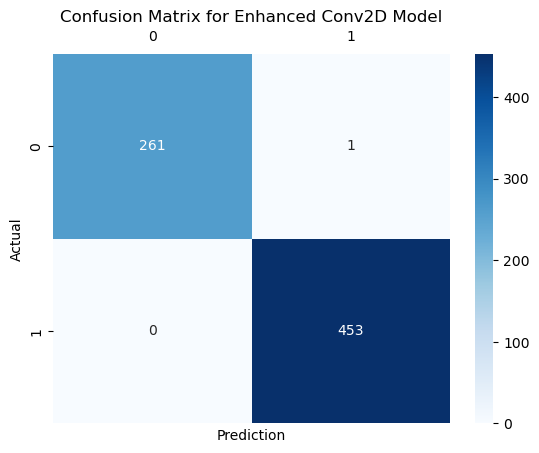


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       453

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



In [31]:
# Confusion Matrix
y_pred = np.where(np.array(model2.predict(X_test, verbose=0)) > 0.5, 1, 0).flatten()

cf = confusion_matrix(y_true=y_test, y_pred=y_pred)
ax = sns.heatmap(cf, annot=True, fmt='.3g', cmap='Blues')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax.set(xlabel='Prediction', ylabel='Actual')
ax.set_title("Confusion Matrix for Enhanced Conv2D Model")

plt.show()

print()
print(classification_report(y_test, y_pred))

---
### <span style="color:skyblue"> Evaluation </span>

In [32]:
# print(f'Baseline Accuracy using Majority Class (Defective): {100*baseline_accuracy: .2f}%')
print()
print(f'Test Accuracy on enhancedCNN model: {100*model2.evaluate(X_test, y_test, verbose=1)[1]: .2f}%')


23/23 [==============================] - 0s 14ms/step - loss: 0.0089 - accuracy: 0.9986
Test Accuracy on enhancedCNN model:  99.86%
